## Import your stuff

In [12]:
import numpy as np
import simulators.faas.simulator as faas
import pydelfi.ndes as ndes
import pydelfi.delfi as delfi
import pydelfi.score as score
import pydelfi.priors as priors
import tensorflow as tf
import rpy2.robjects.numpy2ri
from rpy2.robjects import rinterface, r, IntVector, FloatVector, StrVector
rpy2.robjects.numpy2ri.activate()
tf.logging.set_verbosity(tf.logging.ERROR)
%matplotlib inline
seed = 10

## Set up the prior

Last working prior
upper = [7.700001e+08,  8.400001e+07,  3.200001e+10,  2.500001e+07,  1.600001e+05,
  2.600001e+03,  2.200001e+04,  6.500001e+00,  8.886492e+00,  7.924280e+00,
  1.050516e+01,  7.397941e+00, -3.682371e+00, -4.509306e+00, -6.162727e+00,
 -6.585027e+00,  1.100001e-03, -3.900000e-01]
lower = [7.700000e+08,  8.400000e+07,  3.200000e+10,  2.500000e+07,  1.600000e+05,
  2.600000e+03,  2.200000e+04,  6.500000e+00,  8.886491e+00,  7.924279e+00,
  1.050515e+01,  7.397940e+00, -3.682372e+00, -4.509307e+00, -6.162728e+00,
 -6.585028e+00,  1.100000e-03, -3.900001e-01]

In [13]:
upper = np.array([7.700001e+08,  8.400001e+07,  3.200001e+10,  2.500001e+07,  1.600001e+05,
  2.600001e+03,  2.200001e+04,  6.500001e+00,  8.886492e+00,  7.924280e+00,
  1.050516e+01,  7.397941e+00, -3.682371e+00, -4.509306e+00, -6.162727e+00,
 -6.585027e+00,  1.100001e-03, -3.900000e-01])
lower = np.array([7.700000e+08,  8.400000e+07,  3.200000e+10,  2.500000e+07,  1.600000e+05,
  2.600000e+03,  2.200000e+04,  6.500000e+00,  8.886491e+00,  7.924279e+00,
  1.050515e+01,  7.397940e+00, -3.682372e+00, -4.509307e+00, -6.162728e+00,
 -6.585028e+00,  1.100000e-03, -3.900001e-01])
prior = priors.Uniform(lower, upper)

epsilon_lower = np.array([-1]*94)
epsilon_upper = np.array([1] * 94)
epsilon_prior = priors.Uniform(epsilon_lower, epsilon_upper)


## Set up the simulator
This must have the signature `simulator(parameters, seed, args, batch)` -> `np.array([batch, ndata])`

In [14]:
faasSimulator = faas.faas_Model()

## repeating last fratio for short rows
def simulator(theta, seed, simulator_args, batch):
    
    eps_prior = simulator_args[0]
    eps = eps_prior.draw()
    
    return faasSimulator.simulation(np.concatenate([theta, eps]), seed)[:12,1:]

simulator_args = [epsilon_prior]
theta0 = faasSimulator.theta0

theta = [7.700000e+08,  8.400000e+07,  3.200000e+10,  2.500000e+07,  1.600000e+05,
  2.600000e+03,  2.200000e+04,  6.500000e+00,  8.886491e+00,  7.924279e+00,
  1.050515e+01,  7.397940e+00, -3.682371e+00, -4.509306e+00, -6.162727e+00,
 -6.585027e+00,  1.100000e-03, -3.900000e-01]

print(simulator(theta, 0, simulator_args, 1).shape)
print(len(['K_on_TN', 'K_on_TC', 'K_on_RN', 'K_on_RC', 'K_off_TN', 'K_off_TC', 'K_off_RN', 'K_off_RC', 'logK_on_TN', 'logK_on_TC', 'logK_on_RN', 'logK_on_RC', 'logK_D_TN', 'logK_D_TC', 'logK_D_RN', 'logK_D_RC', 'm_alpha', 'alpha0']))

(12, 259)
18


## Set up the compressor
Must have the signature `compressor(data, args)` -> `np.array([n_summaries])`<br>
In this case we are going to do Gaussian score compression $$\mathbf{t} = \boldsymbol\theta_* + \mathbf{F}^{-1}\nabla_\theta^T\boldsymbol\mu_*\mathbf{C}^{-1}(\mathbf{d}-\boldsymbol\mu_*)$$ using the class `score.Gaussian`. For this we'll need some fiducial parameters, the mean its derivative at the fiducial parameters, the inverse covariance, and the inverse Fisher matrix

In [15]:
def compressor(d, compressor_args):
    comp_d = []
    
    for i in d:
        #mean of final ten entries
        final = np.mean(i[-10:])
        #median of 3 highest points
        peak = np.median(np.sort(i)[-3:])
        #time to peak
        time_peak = np.argmax(i == peak)
        sd = np.std(i[-10:])
        #time to final
        time_final = np.argmax(np.logical_and((i >= final - sd),(i <= final + sd)) == True) + 1
        comp_d.append([final, peak, time_peak])# time_final])
    return np.asarray(comp_d).flatten()
compressor_args=None

## Load in the compressed data

In [16]:
compressed_data = compressor(faasSimulator.data()[:12], compressor_args)

print(compressed_data.shape)

(36,)


## Load in data

In [ ]:
data = faasSimulator.data()[0]
print(data.shape)

## Define ensemble of NDEs

In [6]:
NDEs = [ndes.ConditionalMaskedAutoregressiveFlow(n_parameters=18, n_data=36, n_hiddens=[50,50], n_mades=5, act_fun=tf.tanh, index=0),
        ndes.MixtureDensityNetwork(n_parameters=18, n_data=36, n_components=1, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=1),
        ndes.MixtureDensityNetwork(n_parameters=18, n_data=36, n_components=2, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=2),
        ndes.MixtureDensityNetwork(n_parameters=18, n_data=36, n_components=3, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=3),
        ndes.MixtureDensityNetwork(n_parameters=18, n_data=36, n_components=4, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=4),
        ndes.MixtureDensityNetwork(n_parameters=18, n_data=36, n_components=5, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=5)]


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



## Create DELFI object

In [17]:
DelfiEnsemble = delfi.Delfi(compressed_data, prior, NDEs, 
                       param_limits = [lower, upper],
                       param_names = ['K_on_TN', 'K_on_TC', 'K_on_RN', 'K_on_RC', 'K_off_TN', 'K_off_TC', 'K_off_RN', 'K_off_RC', 'logK_on_TN', 'logK_on_TC', 'logK_on_RN', 'logK_on_RC', 'logK_D_TN', 'logK_D_TC', 'logK_D_RN', 'logK_D_RC', 'm_alpha', 'alpha0'],
                       results_dir = "simulators/faas/results/", save = True)

## Fisher pre-training to initialize the NDEs

## Sequential Neural Likelihood

Population 1/11
Sampling proposal density...
Done.


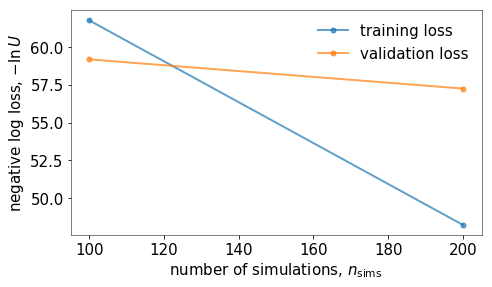

Population 2/11
Sampling proposal density...
Done.


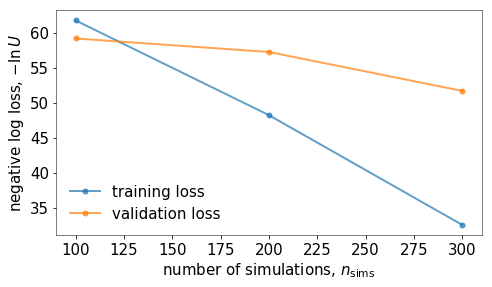

Population 3/11
Sampling proposal density...


/afs/inf.ed.ac.uk/user/s18/s1832582/.conda/envs/thesis/lib/python3.7/site-packages/pydelfi/delfi.py:222: RuntimeWarning: divide by zero encountered in log
  lnL = np.log(L)


Done.


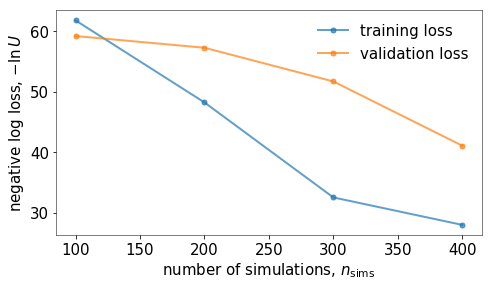

Population 4/11
Sampling proposal density...


/afs/inf.ed.ac.uk/user/s18/s1832582/.conda/envs/thesis/lib/python3.7/site-packages/pydelfi/delfi.py:222: RuntimeWarning: divide by zero encountered in log
  lnL = np.log(L)


Done.


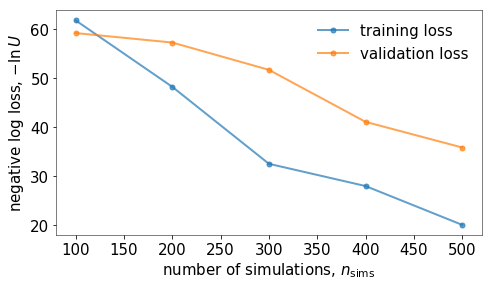

Population 5/11
Sampling proposal density...


/afs/inf.ed.ac.uk/user/s18/s1832582/.conda/envs/thesis/lib/python3.7/site-packages/pydelfi/delfi.py:222: RuntimeWarning: divide by zero encountered in log
  lnL = np.log(L)


Done.


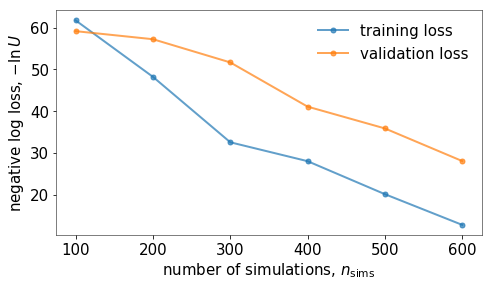

Population 6/11
Sampling proposal density...


/afs/inf.ed.ac.uk/user/s18/s1832582/.conda/envs/thesis/lib/python3.7/site-packages/pydelfi/delfi.py:222: RuntimeWarning: divide by zero encountered in log
  lnL = np.log(L)
/afs/inf.ed.ac.uk/user/s18/s1832582/.conda/envs/thesis/lib/python3.7/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/afs/inf.ed.ac.uk/user/s18/s1832582/.conda/envs/thesis/lib/python3.7/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


Done.


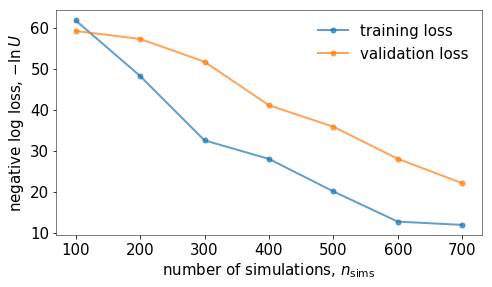

Population 7/11
Sampling proposal density...


/afs/inf.ed.ac.uk/user/s18/s1832582/.conda/envs/thesis/lib/python3.7/site-packages/pydelfi/delfi.py:222: RuntimeWarning: divide by zero encountered in log
  lnL = np.log(L)
/afs/inf.ed.ac.uk/user/s18/s1832582/.conda/envs/thesis/lib/python3.7/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/afs/inf.ed.ac.uk/user/s18/s1832582/.conda/envs/thesis/lib/python3.7/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


Done.


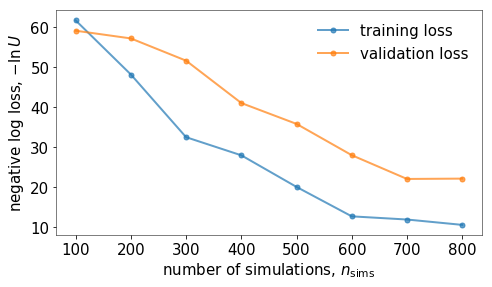

Population 8/11
Sampling proposal density...


/afs/inf.ed.ac.uk/user/s18/s1832582/.conda/envs/thesis/lib/python3.7/site-packages/pydelfi/delfi.py:222: RuntimeWarning: divide by zero encountered in log
  lnL = np.log(L)
/afs/inf.ed.ac.uk/user/s18/s1832582/.conda/envs/thesis/lib/python3.7/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/afs/inf.ed.ac.uk/user/s18/s1832582/.conda/envs/thesis/lib/python3.7/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


Done.


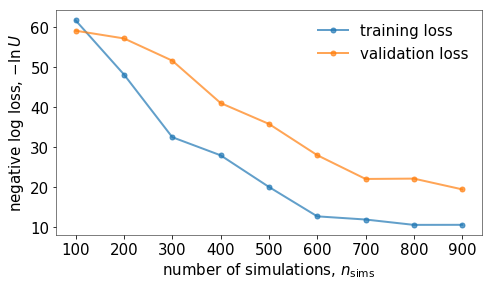

Population 9/11
Sampling proposal density...


/afs/inf.ed.ac.uk/user/s18/s1832582/.conda/envs/thesis/lib/python3.7/site-packages/pydelfi/delfi.py:222: RuntimeWarning: divide by zero encountered in log
  lnL = np.log(L)
/afs/inf.ed.ac.uk/user/s18/s1832582/.conda/envs/thesis/lib/python3.7/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/afs/inf.ed.ac.uk/user/s18/s1832582/.conda/envs/thesis/lib/python3.7/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


Done.


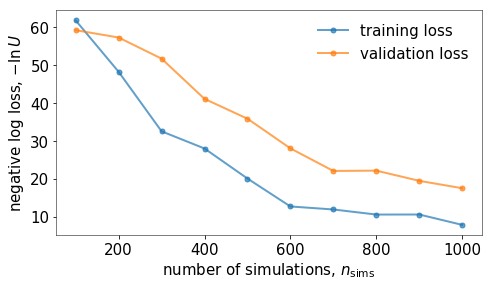

Population 10/11
Sampling proposal density...


/afs/inf.ed.ac.uk/user/s18/s1832582/.conda/envs/thesis/lib/python3.7/site-packages/pydelfi/delfi.py:222: RuntimeWarning: divide by zero encountered in log
  lnL = np.log(L)
/afs/inf.ed.ac.uk/user/s18/s1832582/.conda/envs/thesis/lib/python3.7/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/afs/inf.ed.ac.uk/user/s18/s1832582/.conda/envs/thesis/lib/python3.7/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


Done.


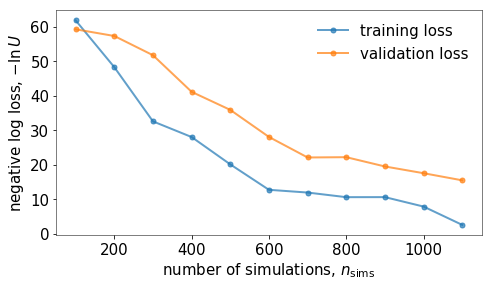

Population 11/11
Sampling proposal density...


/afs/inf.ed.ac.uk/user/s18/s1832582/.conda/envs/thesis/lib/python3.7/site-packages/pydelfi/delfi.py:222: RuntimeWarning: divide by zero encountered in log
  lnL = np.log(L)
/afs/inf.ed.ac.uk/user/s18/s1832582/.conda/envs/thesis/lib/python3.7/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/afs/inf.ed.ac.uk/user/s18/s1832582/.conda/envs/thesis/lib/python3.7/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


Done.


In [ ]:
n_initial = 100
n_batch = 100
n_populations = 11

DelfiEnsemble.sequential_training(simulator, compressor, n_initial, n_batch, n_populations, patience=20., save_intermediate_posteriors=False, simulator_args=simulator_args)

## Sample the learned posterior

In [11]:
posterior_samples = DelfiEnsemble.emcee_sample()
print(posterior_samples.shape)

emcee: Exception while calling your likelihood function:
  params: [ 7.70000055e+08  8.40000072e+07  3.20000060e+10  2.50000054e+07
  1.60000042e+05  2.60000065e+03  2.20000044e+04  6.50000089e+00
  8.88649196e+00  7.92427938e+00  1.05051579e+01  7.39794053e+00
 -3.68237143e+00 -4.50930607e+00 -6.16272793e+00 -6.58502791e+00
  1.10000002e-03 -3.90000017e-01]
  args: []
  kwargs: {}
  exception:


Traceback (most recent call last):
  File "/afs/inf.ed.ac.uk/user/s18/s1832582/.conda/envs/thesis/lib/python3.7/site-packages/emcee/ensemble.py", line 519, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/afs/inf.ed.ac.uk/user/s18/s1832582/.conda/envs/thesis/lib/python3.7/site-packages/pydelfi/delfi.py", line 338, in <lambda>
    log_likelihood = lambda x: self.log_posterior_stacked(x, self.data)[0]
  File "/afs/inf.ed.ac.uk/user/s18/s1832582/.conda/envs/thesis/lib/python3.7/site-packages/pydelfi/delfi.py", line 229, in log_posterior_stacked
    return self.log_likelihood_stacked(theta, data) + self.prior.logpdf(np.atleast_2d(theta))
  File "/afs/inf.ed.ac.uk/user/s18/s1832582/.conda/envs/thesis/lib/python3.7/site-packages/pydelfi/priors.py", line 53, in logpdf
    return np.array([inrange(xx)*np.log(np.prod(self.upper-self.lower)) - (1 - inrange(xx))*1e300 for xx in x])
  File "/afs/inf.ed.ac.uk/user/s18/s1832582/.conda/envs/thesis/lib/python3.7/site-packages/pydel

TypeError: unsupported operand type(s) for -: 'list' and 'list'

## Alright let's plot it!
Feed it a list of `(n_samples, n_parameters)` arrays for making a triangle plot; in this case let's just plot the posterior samples.

In [ ]:
DelfiEnsemble.triangle_plot(samples=[posterior_samples])

## Calibration

In [ ]:
rank = np.zeros(18,9)

for i in range(N):
    ps = prior.draw()
    sims = simulator(ps, 0, simulator_args, 1)
    DelfiEnsemble = delfi.Delfi(sims, prior, NDEs, 
                       param_limits = [lower, upper],
                       param_names = ['K_on_TN', 'K_on_TC', 'K_on_RN', 'K_on_RC', 'K_off_TN', 'K_off_TC', 'K_off_RN', 'K_off_RC', 'logK_on_TN', 'logK_on_TC', 'logK_on_RN', 'logK_on_RC', 'logK_D_TN', 'logK_D_TC', 'logK_D_RN', 'logK_D_RC', 'm_alpha', 'alpha0'],
                       results_dir = "simulators/faas/calib/", save = False)

    
    
    n_initial = 100
    n_batch = 10
    n_populations = 1

    DelfiEnsemble.sequential_training(simulator, compressor, n_initial, n_batch, n_populations, patience=2., save_intermediate_posteriors=False, simulator_args=simulator_args)
    pst = DelfiEnsemble.emcee_sample()[:9]
    for j in range(18):
        for l in range(9):
            rank[j,l] += np.sum(pst[l][j] < ps[j])
        
    
        

